<a href="https://colab.research.google.com/github/Tanay2103/Brain-Tumor-Classification-using-CNN-with-Optimized-SVM/blob/main/Brain_Tumor_Augmented_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pyswarms

CNN with Dropout Layers followed by Optimized SVM on Augmented Data

In [7]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pyswarms as ps

train_dir = '/content/drive/MyDrive/mridata2/Training'
test_dir = '/content/drive/MyDrive/mridata2/Testing'

# Label mapping (glioma, meningioma, pituitary -> 1 (Tumor), notumor -> 0 (No Tumor))
label_mapping = {
    'glioma_tumor': 1,
    'meningioma_tumor': 1,
    'pituitary_tumor': 1,
    'no_tumor': 0
}

# Loading images and labels from directory
def load_data_from_directory(directory):
    images = []
    labels = []
    for label_dir in os.listdir(directory):
        label_path = os.path.join(directory, label_dir)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img, (128, 128))
                img_normalized = img_resized / 255.0
                images.append(img_normalized)
                labels.append(label_mapping[label_dir])
    return np.array(images), np.array(labels)

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# Reshaping data to fit CNN input format
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fitting the generator on the training data
datagen.fit(X_train)

# CNN model with Dropout layers
def create_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Early-stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# CNN Training
cnn_model = create_cnn(input_shape=(128, 128, 1))

# Training the CNN model
cnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Feature extraction using the trained CNN
def extract_features(model, data):
    feature_extractor = Sequential(model.layers[:-2])
    features = feature_extractor.predict(data)
    return features

# Extracted features
X_train_features = extract_features(cnn_model, X_train)
X_test_features = extract_features(cnn_model, X_test)

# Particle Swarm Optimization for SVM hyperparameter optimization
def pso_svm_fitness(params):
    n_particles = params.shape[0]
    fitness_values = []
    for i in range(n_particles):
        C, gamma = params[i, 0], params[i, 1]
        svm = SVC(C=C, gamma=gamma)
        svm.fit(X_train_features, y_train)
        predictions = svm.predict(X_test_features)
        accuracy = accuracy_score(y_test, predictions)
        fitness_values.append(-accuracy)
    return np.array(fitness_values)

bounds = ([0.1, 0.0001], [100, 1])

# PSO Optimization
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

best_cost, best_params = optimizer.optimize(pso_svm_fitness, iters=100, verbose=3)

best_C, best_gamma = best_params
print(f'PSO Optimized C: {best_C}, Optimized gamma: {best_gamma}')

# Optimized SVM using the best parameters from PSO
optimized_svm = SVC(C=best_C, gamma=best_gamma, probability=True)
optimized_svm.fit(X_train_features, y_train)

# Evaluation
predictions = optimized_svm.predict(X_test_features)
accuracy = accuracy_score(y_test, predictions)
print(f'Test Accuracy with optimized SVM: {accuracy}')

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 64s 845ms/step - accuracy: 0.7619 - loss: 0.6476 - val_accuracy: 1.0000 - val_loss: 0.3652
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 871ms/step - accuracy: 0.8372 - loss: 0.3432 - val_accuracy: 0.7135 - val_loss: 0.5194
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 892ms/step - accuracy: 0.8963 - loss: 0.2266 - val_accuracy: 0.9149 - val_loss: 0.2469
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 892ms/step - accuracy: 0.9197 - loss: 0.1735 - val_accuracy: 0.9948 - val_loss: 0.1197
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 883ms/step - accuracy: 0.9391 - loss: 0.1411 - val_accuracy: 0.9931 - val_loss: 0.1013
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 78s 833ms/step - accuracy: 0.9456 - loss: 0.1344 - val_accuracy: 0.9931 - val_loss: 0.0798
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 841ms/step - accuracy: 0.9581 - loss: 0.1033 - val_accuracy: 1.0000 - val_loss: 0.0206
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 79s 793ms/step - accuracy: 0.9439 - loss: 0.1195 - val_accu

2024-10-28 08:46:08,875 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.881
2024-10-28 08:48:07,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8807106598984772, best pos: [57.52035101  0.97022182]


PSO Optimized C: 57.52035100605618, Optimized gamma: 0.9702218247034038
Test Accuracy with optimized SVM: 0.8807106598984772


In [14]:
print(f'Size of X_train: {X_train.shape}')
print(f'Size of X_test: {X_test.shape}')

Size of X_train: (2880, 128, 128, 1)
Size of X_test: (394, 128, 128, 1)


In [8]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation for optimized SVM
cv_scores = cross_val_score(optimized_svm, X_train_features, y_train, cv=5, scoring='f1')

print(f'Cross-Validation F1 Scores: {cv_scores}')
print(f'Mean Cross-Validation F1 Score: {cv_scores.mean():.4f}')

Cross-Validation F1 Scores: [0.994      0.98611111 0.92803437 0.98605578 0.97791165]
Mean Cross-Validation F1 Score: 0.9744


AUC: 0.9329


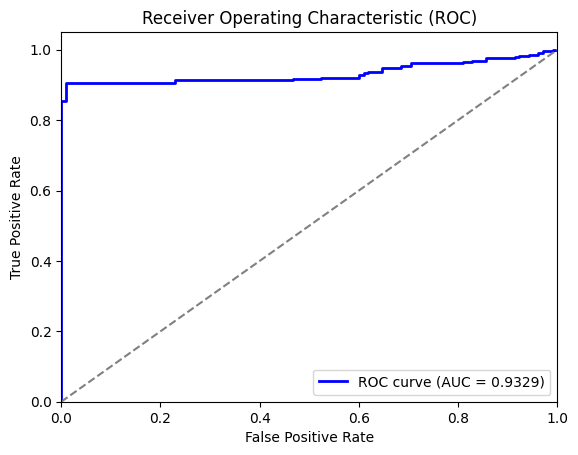

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for the test set
y_pred_prob = optimized_svm.predict_proba(X_test_features)[:, 1]

# Compute ROC curve and AUC value
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Display the AUC value
print(f'AUC: {roc_auc:.4f}')

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [10]:
from sklearn.metrics import f1_score, confusion_matrix

predictions = optimized_svm.predict(X_test_features)

# F1 Score
f1 = f1_score(y_test, predictions)
print(f'F1 Score: {f1}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print('Confusion Matrix:')
print(conf_matrix)

F1 Score: 0.911487758945386
Confusion Matrix:
[[105   0]
 [ 47 242]]


In [11]:
from sklearn.metrics import confusion_matrix

y_pred = optimized_svm.predict(X_test_features)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 1.0000
Recall: 0.8374


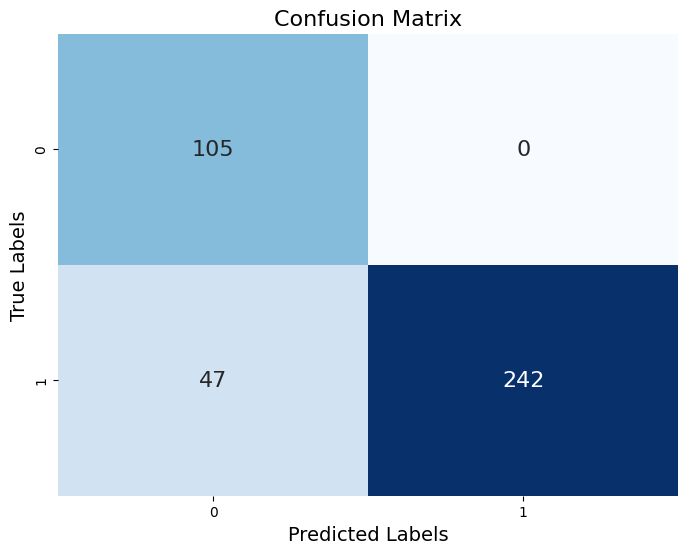

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

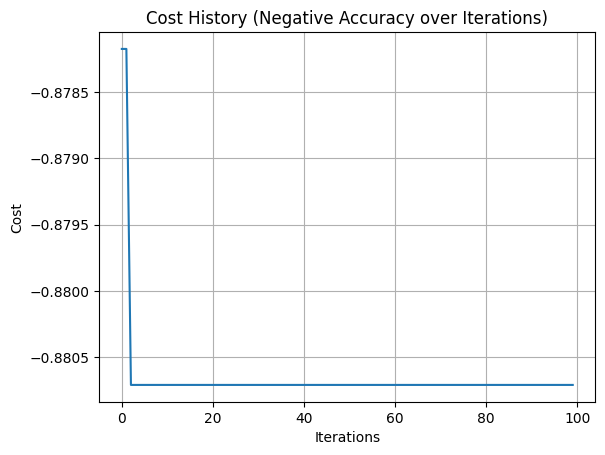

In [16]:
import matplotlib.pyplot as plt

# Plot the cost history (negative accuracy over iterations)
def plot_cost_history(cost_history):
    plt.plot(cost_history)
    plt.title('Cost History (Negative Accuracy over Iterations)')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

plot_cost_history(optimizer.cost_history)